In [1]:
import os
import sys

print(f"The unmodified system path is {sys.path}")
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(f"The modified system path is {sys.path}")    

The unmodified system path is ['/home/user/cjc/openpolicedata/notebooks', '/home/user/.vscode-server/extensions/ms-toolsai.jupyter-2021.11.1001550889/pythonFiles/vscode_datascience_helpers', '/home/user/src', '/home/user/.vscode-server/extensions/ms-toolsai.jupyter-2021.11.1001550889/pythonFiles', '/home/user/.vscode-server/extensions/ms-toolsai.jupyter-2021.11.1001550889/pythonFiles/lib/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/user/cjc/openpolicedata/.venv/lib/python3.8/site-packages', '/home/user/cjc/openpolicedata/.venv/lib/python3.8/site-packages/IPython/extensions', '/home/user/.ipython']
The modified system path is ['/home/user/cjc/openpolicedata/notebooks', '/home/user/.vscode-server/extensions/ms-toolsai.jupyter-2021.11.1001550889/pythonFiles/vscode_datascience_helpers', '/home/user/src', '/home/user/.vscode-server/extensions/ms-toolsai.jupyter-2021.11.1001550889/pythonFiles', '/home/user/.vscode-server/extensions/ms-t

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import openpolicedata as opd
from openpolicedata import *

from shapely.geometry import Point, Polygon


In [3]:
import sys, inspect
clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
print(clsmembers)

[('Point', <class 'shapely.geometry.point.Point'>), ('Polygon', <class 'shapely.geometry.polygon.Polygon'>)]


In [6]:
print(str(opd.TableTypes))
print(dir(data_loaders))


<enum 'TableTypes'>
['FeatureLayerCollection', 'Socrata', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_get_years', 'date', 'default_sodapy_key', 'filter_dataframe', 'get_years_argis', 'get_years_socrata', 'gpd', 'load_arcgis', 'load_geojson', 'load_socrata', 'os', 'pd', 'requests']


In [3]:
print(str(TableTypes))

<enum 'TableTypes'>


In [4]:
source=Source("Denver Police Department")
tables=source.load_from_url(2013)

/home/user/cjc/openpolicedata/openpolicedata/data_loaders.py:78: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return gpd.GeoDataFrame(layer_query_result.sdf,crs=layer_query_result.spatial_reference['wkid'])


In [5]:
tables.table.head(4)

,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID,SHAPE
0,3077577,DPD-13-0233909,P3 Public Need,Subject Stop,8086 S Flower St,2,2013-05-25 11:18:16,File Only,3112899.29,1632571.97,-105.099513,39.569511,None,None,None,c2949d0a-5d06-40a7-b1bf-1a732497fd38,"{""x"": 3112899.28745465, ""y"": 1632571.970544964..."
1,3077594,DPD-13-0037678,P3 Public Need,Vehicle Stop,W Hinsdale Ct / S Wolff St,2,2013-01-24 01:03:32,T - Citation Issued,3127012.26,1636939.92,-105.049374,39.581321,None,None,None,e4df41e0-5bbd-4f67-b9c1-ce3c3afbf531,"{""x"": 3127012.2638218105, ""y"": 1636939.9171896..."
2,3077595,DPD-13-0544413,P3 Public Need,Vehicle Stop,7390 S Webster St,2,2013-11-11 11:02:16,Vehicle Towed,3117807.14,1637326.81,-105.082026,39.582504,None,None,None,47add278-c88f-4a4c-82c5-4924c6628b33,"{""x"": 3117807.1382032335, ""y"": 1637326.8143817..."
3,3077610,DPD-13-0620971,P3 Public Need,Vehicle Stop,Chaple Hill Cemetery / S Colorado Blvd,2,2013-12-27 00:40:54,In Service,3157423.00,1643275.75,-104.941344,39.598251,None,None,None,6901a151-4ba7-4156-850e-54a77ca5089f,"{""x"": 3157422.997619644, ""y"": 1643275.75261504..."


In [5]:
print("opd namespace = " + str(dir(opd)))
print("notebook namespace = " + str(dir()))


opd namespace = ['DataTypes', 'Source', 'TableTypes', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'data', 'data_loaders', 'datasets', 'get', 'os', 'sys']
notebook namespace = ['In', 'Out', 'Point', 'Polygon', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_i5', '_ih', '_ii', '_iii', '_oh', 'clsmembers', 'exit', 'get_ipython', 'gpd', 'inspect', 'module_path', 'opd', 'os', 'pd', 'plt', 'quit', 'sys']


In [3]:
url = 'https://services1.arcgis.com/zdB7qR0BtYrg0Xpl/arcgis/rest/services/ODC_CRIME_STOPS_P/FeatureServer'
date_field = 'TIME_PHONEPICKUP'
year = 2013
df=data_loaders.load_arcgis(url, date_field=date_field, year=year) 

/home/user/cjc/openpolicedata/openpolicedata/data_loaders.py:69: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return gpd.GeoDataFrame(layer_query_result.sdf,crs=layer_query_result.spatial_reference['wkid'])


In [6]:
df.head(1)

,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID,SHAPE
0,3077577,DPD-13-0233909,P3 Public Need,Subject Stop,8086 S Flower St,2,2013-05-25 11:18:16,File Only,3112899.29,1632571.97,-105.099513,39.569511,None,None,None,c2949d0a-5d06-40a7-b1bf-1a732497fd38,"{""x"": 3112899.28745465, ""y"": 1632571.970544964..."


<AxesSubplot:>

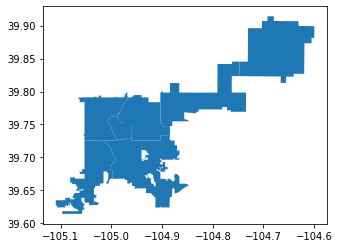

In [12]:
#https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-police-districts
#download https://www.denvergov.org/media/gis/DataCatalog/police_districts/shape/police_districts.zip into data
#Following this example https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

fp = "../data/police_districts/police_districts.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()
map_df.plot()

<AxesSubplot:>

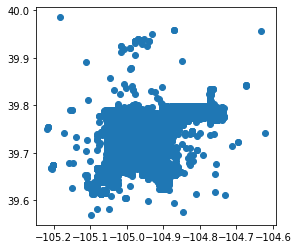

In [16]:
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(df['GEO_LON'],df['GEO_LAT'])]
geodata=gpd.GeoDataFrame(df[['CALL_CLASS','GEO_LON','GEO_LAT']],crs=crs, geometry=geometry)
geodata.plot()

Text(56.75, 0.5, 'Latitude')

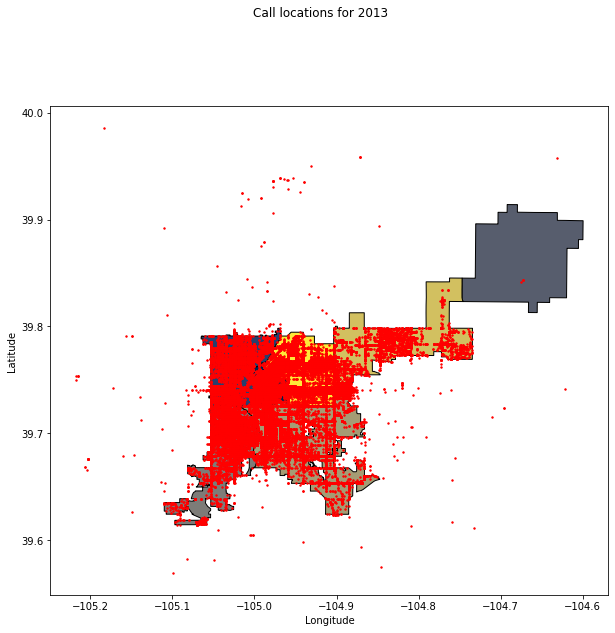

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

map_df.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")

#You can use different 'cmaps' such as jet, plasm,magma, infereno,cividis, binary...(I simply chose cividis)
geodata.plot(ax=ax, color='red', markersize=2);

fig.suptitle('Call locations for 2013', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')
